In [3]:
# import necessary packages

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import re
import seaborn as sns

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
from  pyLDAvis import gensim_models

from gensim.similarities import MatrixSimilarity

import sys
sys.path.append("src\\")
# custom recommendation class
from ScotchRecommender import Scotch_Recommender



C:\Users\prave\anaconda3\envs\sb_cpstone3\lib\site-packages\sklearn\linear_model\_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\prave\anaconda3\envs\sb_cpstone3\lib\site-packages\sklearn\linear_model\_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

In [4]:
# load unified token data
whisk_interdf_path = "data\\interim\\whisk_unified_tokenized.csv"
whisk_data = pd.read_csv(whisk_interdf_path)

In [5]:
# load reduced gensim dict
reduced_gensim_dict_path = "dictionaries\\reduced_gemsimdict_unified.pkl"
reduced_gensim_dict = pickle.load(open(reduced_gensim_dict_path, 'rb'))
print(reduced_gensim_dict)

Dictionary(477 unique tokens: ['barley', 'butter', 'cereal', 'cut_grass', 'fruit']...)


In [6]:
cols_to_keep = ['name', 'token_unified']
unitoken_df = whisk_data[cols_to_keep].set_index('name')

# entries in token_unified are strings. Literal evaluate to get this back into list of strings
attr_listed = [ast.literal_eval(row) for row in unitoken_df['token_unified'] ] 
unitoken_df['tokens'] = attr_listed
# get rid of original token unified column
unitoken_df.drop(columns = ['token_unified'], inplace = True)
unitoken_df.head()

,tokens
name,
Singleton of Dufftown 12 Year Old,"[orange_zest, malty_core, nut, oak, toffee, cu..."
The GlenDronach 18 Year Old Allardice,"[christmas_cake, rum, chocolate, hazelnut, run..."
Lagavulin 2005 (bottled 2020) Pedro Ximénez Cask Finish - Distillers Edition,"[date, prune, almond, bonfire, smoke, toffee, ..."
Glenfarclas 15 Year Old,"[raisin, sherry, orange_peel, walnut, date, in..."
Darkness 8 Year Old,"[amaretti, biscuit, subtly, toast, power, rais..."


Create gensim corpus from reduced dictionary set.

In [7]:
corpus = [reduced_gensim_dict.doc2bow(doc) for doc in unitoken_df.tokens]

In [6]:
# lets pickle the whisky descriptor corpus (reference dictionary is reduced_gensim_dict):
pickle.dump(corpus, open('data\\final\\descriptor_corpus.pkl', 'wb'))

Of course, one of the big issues is that it's not clear what the best number of topics is a priori and whether the topics that an LDA model fits to are actually meaningful. We can use coherence measures (i.e. an aggregation of pairwise correlations between members of a topic as one measure). This can have some issues but its a way of putting a number on estimating topic coherence.

There are also other hyperparameters such as the alpha vector for the Dirichlet distribution.

In [116]:
# let's loop to extract the best hyperparameters and get the topic model coherence score for each hyperparameter set.
model_coherence_list = []
for topic_num in range(2,20, 1):
    # our LDA model
    scotch_topic_model = LdaModel(corpus = corpus, num_topics = topic_num, random_state=100,  id2word = reduced_gensim_dict, passes = 10, alpha = 'auto' )

    # coherence model wrapper
    cm = CoherenceModel(model=scotch_topic_model, texts= unitoken_df.tokens, coherence = 'c_v')
    model_coherence_list.append((topic_num, cm.get_coherence()))
    
print(model_coherence_list)


[(2, 0.2993272541832943), (3, 0.3136807900071163), (4, 0.35908733130685), (5, 0.3735726377031539), (6, 0.37486755012748624), (7, 0.37267587961541854), (8, 0.3534713379917902), (9, 0.37798863377144926), (10, 0.3707958121442076), (11, 0.37322423256263304), (12, 0.34913368873656414), (13, 0.3602244146876927), (14, 0.36407616003603377), (15, 0.3640611499931736), (16, 0.3632675135810002), (17, 0.36519366154047733), (18, 0.3577528042053702), (19, 0.36248111014751244)]


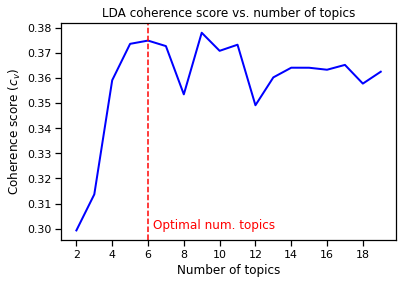

In [340]:
# plot model coherence score vs number of topics
unzipped_coherence_list = list(zip(*model_coherence_list))
plt.plot(unzipped_coherence_list[0], unzipped_coherence_list[1], c = 'b', linewidth = 2 )
plt.axvline(x = 6, c ='r', linestyle = '--')
plt.annotate('Optimal num. topics', xy = (6.3, 0.30), c ='r')
plt.title('LDA coherence score vs. number of topics')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score ($c_v$)')
plt.xticks(np.arange(2,20, 2))
model_image_path = "images\\Modeling\\"
plt.savefig(model_image_path +'LDA_coherence.jpg', dpi = 300, bbox_inches = 'tight')
plt.show()


In [8]:
scotch_topic_model = LdaModel(corpus = corpus, num_topics = 6, random_state= 100,  id2word = reduced_gensim_dict, passes = 10, alpha = 'auto',  minimum_probability = 0 )

In [141]:
scotch_topic_model.show_topics(num_words=30)

[(0,
  '0.049*"chocolate" + 0.042*"fruit" + 0.041*"raisin" + 0.028*"sherry" + 0.026*"cinnamon" + 0.025*"oak" + 0.022*"dark_chocolate" + 0.021*"rich" + 0.017*"spice" + 0.016*"clove" + 0.015*"cherry" + 0.015*"date" + 0.015*"coffee" + 0.015*"orange" + 0.014*"ginger" + 0.013*"sweet" + 0.013*"orange_peel" + 0.012*"sultana" + 0.012*"dark" + 0.010*"cake" + 0.009*"walnut" + 0.009*"plum" + 0.008*"treacle" + 0.008*"toffee" + 0.008*"brown_sugar" + 0.008*"red" + 0.008*"juicy" + 0.008*"caramel" + 0.007*"honey" + 0.007*"thick"'),
 (1,
  '0.033*"vanilla" + 0.030*"oak" + 0.027*"barley" + 0.024*"malt" + 0.023*"honey" + 0.022*"fresh" + 0.019*"chocolate" + 0.018*"sweet" + 0.016*"butter" + 0.016*"apple" + 0.015*"citrus" + 0.014*"lemon" + 0.014*"floral" + 0.013*"cinnamon" + 0.012*"peel" + 0.012*"grass" + 0.011*"sugar" + 0.011*"cream" + 0.011*"orange" + 0.011*"apricot" + 0.010*"spice" + 0.010*"pear" + 0.010*"almond" + 0.010*"caramel" + 0.010*"toasted" + 0.009*"earth" + 0.009*"finish" + 0.009*"peach" + 0.009

In [142]:
vis = gensim_models.prepare(scotch_topic_model, corpus, reduced_gensim_dict, sort_topics = False)
pyLDAvis.display(vis)
pyLDAvis.save_html(vis, 'lda.html')

C:\Users\prave\anaconda3\envs\sb_cpstone3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


Picking the optimal number of topics is not straightforward. The coherence score is just a guide. Ultimately, it depends on what you are going for. In some cases, overlap between topics with increased topic number can be tolerated. In other cases, we want as few topics as is practical. In either case, there are risks of losing some degree of interpretability.

In our case, we went for the model recommended by the coherence score. 

Let's look at this visualization at different values of relevance. At values of lambda = 1, we see that a common descriptor set tends to pile up at the highest saliency in all the topics. "Vanilla", "sweet", "oak", "fruit", "malt", "barley", etc. are examples of such ultra-common descriptors tht seem to be a unifying descriptor set for Scotch. We saw these same descriptors as the most frequent across Scotch regions during EDA. It's not too surprising that these words appear prelevantly in many of the descriptor topic groupings. Or it may not be possible to improve substantially usng a simple BoW.

Looking at lower ranges values of relevance, we see that each topic has real differences and in ways that actually make some sense in terms of tastes.

Number in brackets are the index of each topic in the gensim model.

1. Topic 1 [0]: Sweet, rich, spiced christmas flavors with a mix of nuts, candied berries, aromatic spice, and dark chocolate. These are dark, sweet flavors.
2. Topic 2 [1]: Citrus and floral with cream, malty notes.
3. Topic 3 [2]: Herbal, tannin, citrus, wood spice. Drier notes.
4. Topic 4 [3]: Wood, smoke, and pepper/heat. But also combined with cream and custard. Richness.
5. Topic 5 [4]: Smoke, peat, salt, meat. All the savoury notes.
6. Topic 6 [5]: Berries, rhubarb, dark chocolate, jam, fruits, tartness but sweet.


A quick exploration of the visual shows that many of these topics are meaningful and interpretable but that there are some confused descriptors that one might think would belong in a different topic. The topics are not as clean as one might hope. But the topics do line up with the kinds of thing we were seeing in Correspondence Analysis which is good. We expected the categories to be more of a continuum rather than disjoint descriptions. Getting better results might mean twiddling with the topic number a little, or just iterating over several random initializations, or going back to corpus building and further tailoring the stop word list and stemming/lemmatizing. 

For this project, we'll stick with this model for now and see where it takes us.


In [9]:
doc_lda_decomp = scotch_topic_model[corpus] # for each document (scotch) creates a list of tuples for each scotch with the topic (taste type) and its relative importance.

This gives us a numeric breakdown of each scotch across different relevant taste/smell types as represented by the topics found by LDA. This is what we wanted and was something that the descriptor-scotch joint embedding via Correspondence Analysis could not give us.

Let's do a sanity check and see what we get for some well known Scotches:

In [10]:
#its easier to inspect topic weights for Scotches against each other visually
def plot_topicweights(scotch_name):
    
    doc_num = whisk_data[whisk_data['name'] == scotch_name ].index[0]

    top_breakdown = doc_lda_decomp[doc_num]
    topic_index = np.array(list(zip(*top_breakdown))[0]) + 1
    topic_weight = np.array(list(zip(*top_breakdown))[1])

    top_breakdown_series = pd.Series(data = topic_weight, index=topic_index).sort_values(ascending = False)
    sns.barplot(x = top_breakdown_series.index, y = top_breakdown_series.values)
    plt.xlabel('Topic')
    plt.ylabel('Weights')
    plt.title(scotch_name)
    plt.show()
        


In [34]:
def plot_two_scotchweights(name_list, filename = None, for_pres = False):
    num_cols = 1
    num_rows = 2
    doc_num_list = [whisk_data[whisk_data['name'] == scotch_name].index[0] for scotch_name in name_list]
    fig, ax = plt.subplots(num_rows,num_cols, figsize = (2.5,5))

    for index,doc_num in enumerate(doc_num_list):
        name = name_list[index]
        top_breakdown = doc_lda_decomp[doc_num]
        topic_index = np.array(list(zip(*top_breakdown))[0]) + 1
        topic_weight = np.array(list(zip(*top_breakdown))[1])
        top_breakdown_series = pd.Series(data = topic_weight, index=topic_index).sort_values(ascending = False)
        sns.barplot(x = top_breakdown_series.index, y = top_breakdown_series.values, ax = ax[index])
        ax[index].set_title(name)
        ax[index].set_xlabel('Taste Group')
        ax[index].set_ylabel('Weight')

    plt.tight_layout()
    if ((for_pres == True) & (filename != None)):
        pres_image_path = "reports\\presentation\\"
        plt.savefig(pres_image_path + filename +  '.jpg', dpi = 300, bbox_inches = 'tight' )
    else:
        model_image_path = "images\\EDA\\"
        plt.savefig(model_image_path +'scotch_topic_breakdown.jpg', dpi = 300, bbox_inches = 'tight' )
    plt.show()

In [11]:
import itertools

In [25]:
def plot_multiplescotchweights(name_list, filename = None, for_pres = False):
    num_cols = 2
    num_rows = int(len(name_list)//2)
    ax_indexer = list(itertools.product(range(num_rows), range(num_cols)))

    doc_num_list = [whisk_data[whisk_data['name'] == scotch_name].index[0] for scotch_name in name_list]
    fig, ax = plt.subplots(num_rows,num_cols, figsize = (7,8))

    for index,doc_num in enumerate(doc_num_list):
        name = name_list[index]
        top_breakdown = doc_lda_decomp[doc_num]
        topic_index = np.array(list(zip(*top_breakdown))[0]) + 1
        topic_weight = np.array(list(zip(*top_breakdown))[1])
        top_breakdown_series = pd.Series(data = topic_weight, index=topic_index).sort_values(ascending = False)
        sns.barplot(x = top_breakdown_series.index, y = top_breakdown_series.values, ax = ax[ax_indexer[index]])
        ax[ax_indexer[index]].set_title(name)
        ax[ax_indexer[index]].set_xlabel('Taste Group')
        ax[ax_indexer[index]].set_ylabel('Weight')

    plt.tight_layout()
    if ((for_pres == True) & (filename != None)):
        pres_image_path = "reports\\presentation\\"
        plt.savefig(pres_image_path + filename +  '.jpg', dpi = 300, bbox_inches = 'tight' )
    else:
        model_image_path = "images\\EDA\\"
        plt.savefig(model_image_path +'scotch_topic_breakdown.jpg', dpi = 300, bbox_inches = 'tight' )
    plt.show()



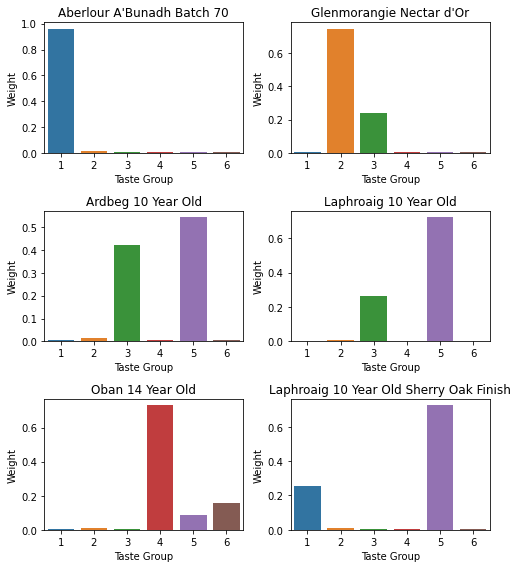

In [26]:
whisky_list = ["Aberlour A'Bunadh Batch 70","Glenmorangie Nectar d'Or", 'Ardbeg 10 Year Old', 'Laphroaig 10 Year Old', "Oban 14 Year Old", "Laphroaig 10 Year Old Sherry Oak Finish"]
plot_multiplescotchweights(whisky_list)

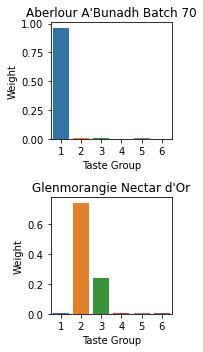

In [37]:
whisky_list = ["Aberlour A'Bunadh Batch 70","Glenmorangie Nectar d'Or"]
plot_two_scotchweights(whisky_list, filename = "sweetsidetopics", for_pres = True)

Let's print the tokens for these whiskies:

In [357]:
for scotch in whisky_list:
    print(scotch, whisk_data[whisk_data['name'] == scotch].token_unified.values)

Aberlour A'Bunadh Batch 70 ["['gingerbread', 'orange_zest', 'black_pepper', 'thick', 'sherry', 'vanilla_pod', 'christmas_cake', 'cherry', 'bakewells', 'hefty', 'helping', 'cinnamon', 'cedar', 'cinnamon', 'raisin']"]
Glenmorangie Nectar d'Or ["['silk', 'syrup', 'syrup', 'sponge', 'vanilla', 'custard', 'butter', 'baklava', 'toasted', 'brown_sugar', 'sweet', 'citrus', 'lemon_curd', 'vanilla', 'shortbread', 'oak', 'spice', 'gingerbread', 'fruit', 'drizzle', 'runny_honey', 'dr', 'oak', 'lemon', 'shortbread', 'gingersnap_biscuit']"]
Ardbeg 10 Year Old ["['sweet', 'vanilla', 'lemon', 'lime', 'ardbeg', 'smoke', 'love', 'ridge', 'vanilla', 'mountain', 'peat', 'citrus', 'fruit', 'cloud', 'sea_spray', 'long', 'glorious', 'sea', 'caramel', 'beach_bonfire', 'smoke']"]
Laphroaig 10 Year Old ["['seaweed', 'vanilla', 'ice_cream', 'whiff', 'aid', 'box', 'tcp', 'plaster', 'etc', 'oak', 'big', 'way', 'fore', 'whisky', 'tongue', 'upsurge', 'spice', 'cardamom', 'black_pepper', 'chilli', 'big', 'muscular', 

The taste descriptors and the topic breakdown align well. We've tried many other whiskies too and it seems good.

This is alright. Let's pickle the model.

In [15]:
LDA_model_path = "models\\Scotch_LDA.pkl"
pickle.dump(scotch_topic_model, open(LDA_model_path, 'wb'))

Let's also construct a new dataframe with the seven topics as features. We can discard the unified_tokens or BoW representation. This can be used for higher level analytics. We can the save this:

# Similarity measures: Content-based recommender systems

In [16]:
index = MatrixSimilarity(doc_lda_decomp) 

In [17]:
# We'll reuse this index object for matrix similarity often for in-corpus recommendation. let's save this.
pickle.dump(index, open('data\\final\\index_sim.pkl', 'wb'))

## In-corpus recommendation

We've created a class that can do in-corpus recommendations and out-of-corpus recommendations. The in-corpus recommender takes in the name of a Scotch and the number of recommendations and outputs the Scotches with the nearest cosine similarity scores. Let's evaluate the LDA-based recommender on a few scotches to see if its making reasonable recommendations.

In [38]:
rec_engine = Scotch_Recommender()

In [367]:
print(whisk_data[whisk_data['name'] == "Aberlour A'Bunadh Batch 70"].token_unified.values)
for x in rec_engine.get_recommendations("Aberlour A'Bunadh Batch 70", 20).values[1:7]:
    print(x, whisk_data[whisk_data['name'] == x].token_unified.values )

["['gingerbread', 'orange_zest', 'black_pepper', 'thick', 'sherry', 'vanilla_pod', 'christmas_cake', 'cherry', 'bakewells', 'hefty', 'helping', 'cinnamon', 'cedar', 'cinnamon', 'raisin']"]
Edradour 10 Year Old 2004 (cask 433) - Straight From The Cask ["['brown_sugar', 'treacle', 'clove', 'cinnamon', 'load', 'raisin', 'walnut_loaf', 'damson_jam', 'richly', 'chocolate', 'rum', 'like', 'spice', 'chocolate', 'date']"]
The GlenDronach Cask Strength - Batch 7 ["['chocolate', 'coffee_bean', 'heavy', 'brown_sugar', 'roasted_nut', 'gingerbread', 'cinnamon', 'blackcurrant', 'vanilla_pod', 'earth', 'rich', 'mature_oak', 'chocolate', 'truffle']"]
Tamdhu 10 Year Old ["['soft', 'red', 'fruit', 'brown_sugar', 'clove', 'chocolate', 'brazil_nut', 'dry', 'orange_peel', 'red_wine', 'pecan', 'raspberry_jam', 'crystallised_ginger', 'cacao', 'juicy', 'blackcurrant']"]
Kingsbarns Balcomie ["['pineapple', 'upside_cake', 'marmalade', 'cinnamon', 'cocoa', 'cinnamon', 'scroll', 'hot_cross', 'bun', 'drizzle', 'ma

Glendronach Port wood is forward in berries, raisin type tastes: sweet and jammy. Some wood/heat, bitter/citrus, and creamy vanilla. Many of the whiskies on this list have similar taste profiles.

Definitely lots of berry/fruit, jam, some bitter/orange notes, some cream, etc. This is good. Finally let's finish up with something that's peaty, quite medicinal, and fiery.

In [364]:
print("Laphroaig 10 Year Old", whisk_data[whisk_data['name'] == "Laphroaig 10 Year Old"].token_unified.values)
for x in rec_engine.get_recommendations("Laphroaig 10 Year Old", 20).values[1:7]:
    print(x, whisk_data[whisk_data['name'] == x].token_unified.values )


Laphroaig 10 Year Old ["['seaweed', 'vanilla', 'ice_cream', 'whiff', 'aid', 'box', 'tcp', 'plaster', 'etc', 'oak', 'big', 'way', 'fore', 'whisky', 'tongue', 'upsurge', 'spice', 'cardamom', 'black_pepper', 'chilli', 'big', 'muscular', 'peat', 'spice', 'liquorice', 'big', 'dose', 'salt', 'whisky', 'slightly', 'sweet', 'recent', 'year', 'beauty', 'classic', 'iodine', 'plaster', 'cool_wood', 'smoke', 'big', 'savoury', 'tarry', 'iodine']"]
Bowmore 22 Year Old 1989 - Mission (Murray McDavid) ["['peat', 'salt', 'floral', 'vanilla', 'zest', 'time', 'vanilla_pod', 'oatmeal', 'hay', 'heather', 'sea_air', 'lemon', 'lime', 'sea_spray', 'ream', 'smoke', 'pleasantly', 'long', 'finish']"]
Coastal Confection 1996 (bottled 2015) - Wemyss Malts (Bowmore) ["['peat', 'slightly', 'coastal', 'plenty', 'fruit', 'way', 'sweet', 'n', 'peat', 'sugar', 'peel', 'fruit', 'sweetie', 'balanced', 'satisfying']"]
Caol Ila 20 Year Old 1995 (cask 10870) - Old Particular (Douglas Laing) ["['salt', 'slice', 'lemon', 'pine

Again...pretty good. How about a citrus forward, lighter scotch? 

In [90]:
 
print("The Glenlivet 12 Year Old", whisk_data[whisk_data['name'] == "The Glenlivet 12 Year Old"].token_unified.values)
for x in rec_engine.get_recommendations("The Glenlivet 12 Year Old", 20).values[1:7]:
    print(x, whisk_data[whisk_data['name'] == x].token_unified.values )


The Glenlivet 12 Year Old ["['butter', 'vanilla', 'rich', 'bright', 'fruit', 'apricot', 'pineapple', 'greengage', 'citrus_blossom', 'toasted_teacake', 'soft', 'crackle', 'oak', 'spice', 'malt', 'plus', 'red', 'apple', 'juicy']"]
Glenmorangie X ["['lot', 'vanilla', 'apricot', 'apple', 'flaked', 'almond', 'later', 'honeyed', 'malt', 'lemon', 'apple', 'plus', 'nutmeg', 'oak', 'warmth', 'honeyed', 'orchard_fruit', 'theme', 'finish', 'pinch', 'peppercorn']"]
Tullibardine 24 Year Old 1993 (cask 12026) - Old Particular (Douglas Laing) ["['zest', 'tropical_fruit', 'starfruit', 'mango', 'pine', 'cedar', 'porridge', 'rye_bread', 'oven', 'classic', 'herbaceous', 'spice', 'tow', 'cream', 'vanilla', 'subtle']"]
Tormore - Batch 2 (That Boutique-y Whisky Company) ["['caramelised', 'orange_peel', 'fresh', 'lime', 'grapefruit', 'support', 'apple', 'golden', 'barley', 'core', 'steamed', 'marmalade', 'pudding', 'flourless', 'orange', 'cake', 'crushed', 'almond', 'apple', 'peel', 'juicy', 'barley', 'crisp

Again, pretty good. LDA on our BoW corpus is definitely doing a decent job at grouping whiskies with nearby combinations of broad taste categories. But we may want to input our own or someone else's tasting notes of a whisky directly. Or we just have a set of tastes and smells in mind and want to get a Scotch recommendation.

## Out-of-Corpus Recommendation

Let's try our hand with a description for a light and dry scotch with citrus notes as well as salt and coastal influences.

In [111]:
for x in rec_engine.recommend_from_text(text="light, citrus, lemon, grapefruit, dry, crisp, sea salt, salted caramel").values[1:9]:
    print(x, whisk_data[whisk_data['name'] == x].token_unified.values )

Springbank 12 Year Old Cask Strength - 52.2% ["['calm', 'eye', 'storm', 'heather', 'coriander', 'oregano', 'caramel', 'busy', 'harbour', 'industrial', 'maritime', 'aroma', 'water', 'grape', 'springbank', 'rhubarb', 'thick', 'heavy', 'smoke', 'industrial', 'massive', 'long']"]
Lemon Buttered Kippers 1997 (bottled 2015) - Wemyss Malts (Bunnahabhain) ["['burst', 'lemon', 'sweet', 'coastal', 'smoke', 'caramel', 'light', 'bbq', 'smoke', 'thyme', 'toffee', 'toasted', 'malt', 'fruit', 'slightly', 'refreshing']"]
Caol Ila 10 Year Old 2009 (cask 318769) - Berry Bros. & Rudd ["['coastal', 'peat', 'whiff', 'citrus', 'vanilla', 'oil', 'barley', 'phenol', 'damp', 'oak', 'bright', 'zest', 'citrus', 'cask', 'finish']"]
Longrow Peated ["['light', 'sweet', 'green', 'grape', 'rhubarb', 'great', 'contrast', 'big', 'blast', 'smoke', 'salt', 'leather', 'fore', 'maritime', 'combination', 'harbourmaster', 'jacket', 'salt', 'return', 'deeply', 'satisfying', 'ending']"]
Islay 9 Year Old 2008 (Single Cask Natio

Wow thats better than I expected honestly. I actually had a Springbank in mind.

In [156]:
print(whisk_data[whisk_data['name'] == 'The GlenDronach 18 Year Old Allardice'].token_unified.values)

["['christmas_cake', 'rum', 'chocolate', 'hazelnut', 'runny_honey', 'sauternes', 'sherry', 'thick', 'knife', 'old', 'rum', 'pineapple', 'brown_sugar', 'tow', 'fresh', 'blackcurrant', 'blueberry', 'pancake', 'generous', 'helping', 'maple_syrup']"]


In [152]:
whisk_data[0:20]

,Unnamed: 0,name,price,region,distillery,bottler,age,ABV,chill_filter,cask_strength,...,maturation_oak,maturation_port,maturation_red wine,maturation_rum,maturation_rye,maturation_sauternes,maturation_sherry,maturation_white wine,maturation_wine,token_unified
0,0,Singleton of Dufftown 12 Year Old,40.42,Speyside Whisky,Dufftown,Dufftown,12.0,40.0,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"['orange_zest', 'malty_core', 'nut', 'oak', 't..."
1,1,The GlenDronach 18 Year Old Allardice,112.30,Highland Whisky,GlenDronach,GlenDronach,18.0,46.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"['christmas_cake', 'rum', 'chocolate', 'hazeln..."
2,2,Lagavulin 2005 (bottled 2020) Pedro Ximénez Ca...,99.70,Islay Whisky,Lagavulin,Lagavulin,NaN,43.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"['date', 'prune', 'almond', 'bonfire', 'smoke'..."
3,3,Glenfarclas 15 Year Old,56.12,Speyside Whisky,Glenfarclas,Glenfarclas,15.0,46.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['raisin', 'sherry', 'orange_peel', 'walnut', ..."
4,4,Darkness 8 Year Old,57.28,Scotch Whisky,Darkness,Darkness,8.0,47.8,False,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,"['amaretti', 'biscuit', 'subtly', 'toast', 'po..."
5,5,Tobermory 12 Year Old,52.68,Island Whisky,Tobermory,Tobermory,12.0,46.3,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"['rounded', 'malt', 'oil', 'hearty_helping', '..."
6,6,Laphroaig 16 Year Old,102.00,Islay Whisky,Laphroaig,Laphroaig,16.0,48.0,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"['rich', 'peat', 'iodine', 'subtle', 'floral',..."
7,7,Balvenie 14 Year Old Caribbean Cask,65.30,Speyside Whisky,Balvenie,Balvenie,14.0,43.0,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"['sweet', 'vanilla', 'cream', 'apple', 'mango'..."
8,8,Balvenie 21 Year Old PortWood Finish,200.65,Speyside Whisky,Balvenie,Balvenie,21.0,40.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"['gentle', 'subtle', 'load', 'mix', 'cranberry..."
9,9,Macallan 28 Year Old (That Boutique-y Whisky C...,1261.20,Speyside Whisky,The Macallan,That Boutique-y Whisky Company,28.0,43.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['delicate', 'smooth', 'oil', 'mouthfeel', 'mi..."
